In [1]:
from langchain.embeddings import HuggingFaceEmbeddings

from langchain.schema import Document
from langchain.vectorstores import Milvus as OriginalMilvus
import os

In [2]:
from typing import Any, Dict, List, Optional, Tuple
from langchain.vectorstores.milvus import logger

In [3]:
class Milvus(OriginalMilvus):
    def similarity_search_with_score(
        self,
        query: str,
        k: int = 4,
        param: Optional[dict] = None,
        expr: Optional[str] = None,
        timeout: Optional[int] = None,
        **kwargs: Any,
    ) -> List[Tuple[Document, float]]:
        """Perform a search on a query string and return results with score.

        For more information about the search parameters, take a look at the pymilvus
        documentation found here:
        https://milvus.io/api-reference/pymilvus/v2.2.6/Collection/search().md

        Args:
            query (str): The text being searched.
            k (int, optional): The amount of results to return. Defaults to 4.
            param (dict): The search params for the specified index.
                Defaults to None.
            expr (str, optional): Filtering expression. Defaults to None.
            timeout (int, optional): How long to wait before timeout error.
                Defaults to None.
            kwargs: Collection.search() keyword arguments.

        Returns:
            List[float], List[Tuple[Document, any, any]]:
        """
        if self.col is None:
            logger.debug("No existing collection to search.")
            return []

        # Embed the query text.
        embedding = self.embedding_func.embed_query(query, param=param)

        res = self.similarity_search_with_score_by_vector(
            embedding=embedding, k=k, param=param, expr=expr, timeout=timeout, **kwargs
        )
        return res

In [4]:
from tqdm import tqdm

In [5]:
dir_path = os.getcwd()
dir_path

'/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search'

In [6]:
from geo_utils import (
    crop_middle_image_from_side_size,
    apply_circle_mask,
)
from PIL import Image

device = "mps"


def preprocess_image(image: Image.Image, param: dict = None) -> Image.Image:
    DEBUG = False
    # image = crop_middle_image_from_side_size(image, 2400, 1600)
    rotation = None
    do_flip = None

    if param is not None:
        rotation = param.get("rotation", None)
        do_flip = param.get("do_flip", None)
        DEBUG = param.get("DEBUG", False)
    if rotation is not None:
        image = image.rotate(rotation)
    if do_flip is not None:
        if do_flip:
            image = image.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)
    image = apply_circle_mask(image)
    image = image.resize((512, 512))
    if DEBUG:
        image.save(f"{dir_path}/debug.png")
        raise
    return image


def predict(
    model,
    transforms,
    image_path,
    device=device,
    param=None,
):
    image = Image.open(image_path).convert("RGB")
    preprocessed_image = preprocess_image(image, param)
    image_tensor = (
        transforms(preprocessed_image).unsqueeze(0).to(device)
    )  # Move input data to the GPU
    # output = model(image_tensor)

    # or equivalently (without needing to set num_classes=0)
    output = model.forward_features(image_tensor)
    output = model.forward_head(output, pre_logits=True)
    embedding = output.detach().cpu().numpy()[0]
    # save preprocessed_image
    return embedding


import timm


class ImageEmbedding:
    def __init__(
        self, model_name: str = "maxvit_tiny_tf_512.in1k", device: str = "mps"
    ):
        """Initialize the sentence_transformer."""
        self.device = device
        self.model = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=0,  # remove classifier nn.Linear
        ).to(self.device)
        self.model = self.model.eval()
        data_config = timm.data.resolve_model_data_config(self.model)
        transforms = timm.data.create_transform(**data_config, is_training=False)
        self.transforms = transforms

    def embed_documents(
        self,
        image_paths: List[str],
        param: dict = None,
    ) -> List[List[float]]:
        """Compute doc embeddings using a HuggingFace transformer model.

        Args:
            image_paths: The list of image_path to embed.

        Returns:
            List of embeddings, one for each text.
        """
        embeddings = []
        for image_path in tqdm(image_paths, desc="Processing images"):
            embedding = predict(
                model=self.model,
                transforms=self.transforms,
                image_path=image_path,
                param=param,
            )

            embeddings.append(embedding)
        return embeddings

    def embed_query(self, text: str, param: dict = None) -> List[float]:
        """Compute query embeddings using a HuggingFace transformer model.

        Args:
            text: The text to embed.

        Returns:
            Embeddings for the text.
        """
        return self.embed_documents([text], param=param)[0]

In [7]:
embeddings = ImageEmbedding()

In [8]:
image_path = "/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/7.png"
query_result = embeddings.embed_query(image_path)

Processing images:   0%|          | 0/1 [00:00<?, ?it/s]

Processing images: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


In [9]:
print(len(query_result))
query_result[:10]

512


array([-0.08048439, -0.63643837,  0.02220488, -0.15575267, -0.21804258,
        0.5358038 , -0.4803476 ,  0.51184416, -0.29203358,  0.77110773],
      dtype=float32)

In [10]:
print(len(query_result))
query_result[:10]

512


array([-0.08048439, -0.63643837,  0.02220488, -0.15575267, -0.21804258,
        0.5358038 , -0.4803476 ,  0.51184416, -0.29203358,  0.77110773],
      dtype=float32)

In [11]:
image_folder = f"{dir_path}/crop_image"
image_paths = [f"{image_folder}/{i}" for i in os.listdir(image_folder)]
image_paths[:10]

['/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/8820.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/348.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/12085.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/1804.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/4968.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/10686.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/12091.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/15098.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/6819.png',
 '/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/8834.png

In [12]:
# load poi features
import pandas as pd

store_with_poi_df_path = "/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/seven_eleven_location_gdf_with_poi.feather"
store_with_poi_df = pd.read_feather(store_with_poi_df_path)
store_with_poi_df.shape

(11118, 474)

In [13]:
store_with_poi_df.columns

Index(['store_id', 'prov_namt', 'latitude', 'longitude', 'geometry',
       'competitors', 'cross_street', 'education_area', 'entertainment_area',
       'entry_point',
       ...
       'ด่านศุลกากร', 'ท่าเรือพาณิชย์', 'โรงภาพยนตร์', 'อุทยานแห่งชาติ',
       'สหกรณ์', 'ศูนย์สวัสดิการ/สถานสงเคราะห์', 'สวนสัตว์/พิพิธภัณฑ์สัตว์น้ำ',
       'ศูนย์การขนส่งสินค้า', 'สถานบันเทิงตอนกลางคืน',
       'สถานีบริการน้ำมันโมบิล'],
      dtype='object', length=474)

In [14]:
# drop 'prov_namt', 'latitude', 'longitude', 'geometry',
store_with_poi_df = store_with_poi_df.drop(
    columns=["prov_namt", "latitude", "longitude", "geometry"]
)
store_with_poi_df.columns

Index(['store_id', 'competitors', 'cross_street', 'education_area',
       'entertainment_area', 'entry_point', 'gas_stations', 'government_area',
       'healthcare_centers', 'high_rise_residential',
       ...
       'ด่านศุลกากร', 'ท่าเรือพาณิชย์', 'โรงภาพยนตร์', 'อุทยานแห่งชาติ',
       'สหกรณ์', 'ศูนย์สวัสดิการ/สถานสงเคราะห์', 'สวนสัตว์/พิพิธภัณฑ์สัตว์น้ำ',
       'ศูนย์การขนส่งสินค้า', 'สถานบันเทิงตอนกลางคืน',
       'สถานีบริการน้ำมันโมบิล'],
      dtype='object', length=470)

In [15]:
image_paths[0]

'/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/8820.png'

In [16]:
TEST = False
# TEST = True
TEST_NUM = 1000
select_columns = [
    "low_rise_residential_area",
    "office_building",
    "entertainment_area",
    "government_area",
    "entry_point",
    "high_rise_residential",
    "education_area",
    "healthcare_centers",
    "industrial_area",
    "housing_residential_area",
    "tourism_area",
    "gas_stations",
    "competitors",
    "market_area",
    "public_transportation",
    "transportation_center",
    "utern",
    "cross_street",
]
# select_columns = [
#     "competitors",
# ]


docs = []
for ind, image_path in enumerate(image_paths):
    if TEST and ind >= TEST_NUM:
        break
    # store_id = image_path.split("/")[-1].split(".")[0]
    # store_id = int(store_id)
    # # print(store_id)
    # store_poi_data = store_with_poi_df[store_with_poi_df["store_id"] == store_id]
    # # drop store_id
    # store_poi_data = store_poi_data.drop(columns=["store_id"])
    # store_poi_metadata = store_poi_data.to_dict(orient="records")[0]
    # # use only key in select_columns
    # store_poi_metadata = {
    #     k: v for k, v in store_poi_metadata.items() if k in select_columns
    # }
    docs.append(
        Document(
            page_content=image_path,
            # metadata=store_poi_metadata,
        )
    )
if TEST:
    collection_name = "reverse_image_search_milvus_test"
else:
    collection_name = "reverse_image_search_milvus_new"
collection_name, len(docs), docs[0]

('reverse_image_search_milvus_new',
 11118,
 Document(page_content='/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/8820.png'))

In [17]:
# store_poi_data.to_dict(orient="records")[0]

In [18]:
# check if collection exists
is_exist = True
try:
    vector_store = Milvus(
        embeddings,
        connection_args={
            "host": "localhost",
            "port": 19530,
            "maxFieldNum": 256,
        },
        search_params={"metric_type": "L2", "params": {"ef": 20000}},
        collection_name=collection_name,
    )
    input_image_path = "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data_7_eleven_google_map_zoom16_7/crop_image/18564.png"
    search_results = vector_store.similarity_search(
        query=input_image_path,
        k=10,
        # where_filter={"keyword": "เสื้อ"},
    )
    if search_results == []:
        raise Exception("collection not exists")
    print("collection exists")
except Exception as e:
    is_exist = False

Processing images: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

collection exists


In [19]:
if is_exist is False:
    vector_store = Milvus.from_documents(
        docs,
        embedding=embeddings,
        collection_name=collection_name,
        connection_args={"host": "localhost", "port": 19530, "maxFieldNum": 256},
    )

In [20]:
input_image_path = "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data_7_eleven_google_map_zoom16_7/crop_image/18564.png"
input_image_path = "/Users/user/Documents/Coding/cro_location_intelligence/notebook/data_7_eleven_google_map_zoom16_7/crop_image/1025.png"
search_results = vector_store.similarity_search(
    query=input_image_path,
    k=10000,
    # where_filter={"keyword": "เสื้อ"},
)

Processing images: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


In [21]:
len(search_results)

10000

In [22]:
from typing import Tuple


def remove_duplicate(
    search_results: Tuple[Document, float], max_result: int
) -> Tuple[Document, float]:
    search_results = sorted(search_results, key=lambda x: x[1], reverse=False)

    unique_content_set = set()
    best_result = []

    for result in search_results:
        if result[0].page_content not in unique_content_set:
            unique_content_set.add(result[0].page_content)
            best_result.append(result)

    best_result = best_result[:max_result]
    return best_result


def advance_search(
    input_image_path: str,
    num_rotation: int = 4,
    do_flip: bool = False,
    DEBUG: bool = False,
    max_result: int = 15000,
) -> Tuple[Document, float]:
    search_results = []
    rotation_list = [i for i in range(0, 360, 360 // num_rotation)]
    if do_flip:
        do_flip_list = [True, False]
    else:
        do_flip_list = [False]
    for do_flip in do_flip_list:
        for rotation in rotation_list:
            param = {
                "rotation": rotation,
                "do_flip": do_flip,
                "DEBUG": DEBUG,
            }
            search_results += vector_store.similarity_search_with_score(
                query=input_image_path,
                k=max_result,
                param=param,
                # where_filter={"keyword": "เสื้อ"},
            )
    best_result = remove_duplicate(search_results, max_result)
    return best_result

In [23]:
search_results = advance_search(input_image_path, num_rotation=4, do_flip=False)

Processing images: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


In [24]:
from itertools import permutations

store_ids = [1, 2, 3]

# Generate all permutations of store IDs
store_id_permutations = permutations(
    store_ids, 2
)  # Change 2 to the desired length of permutations
store_id_permutations = list(store_id_permutations)
store_id_permutations

[(1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)]

In [25]:
import numpy as np


# create a df for store_id
store_id_list = []
for input_image_path in image_paths:
    store_id = input_image_path.split("/")[-1].split(".")[0]
    store_id = int(store_id)
    store_id_list.append(store_id)
store_id_permutations = permutations(store_id_list, 2)
store_id_permutations = list(store_id_permutations)
result_search_df = pd.DataFrame(
    store_id_permutations, columns=["input_store_id", "pred_store_id"]
)
result_search_df["score"] = np.nan
print(result_search_df.shape)
result_search_df.head()

(123598806, 3)


input_store_id  pred_store_id  score
0            8820            348    NaN
1            8820          12085    NaN
2            8820           1804    NaN
3            8820           4968    NaN
4            8820          10686    NaN

In [35]:
# fail_list = []

# for image_ind, image_path in enumerate(image_paths):
#     try:
#         search_results = advance_search(image_path, num_rotation=4, do_flip=False)
#         input_store_id = image_path.split("/")[-1].split(".")[0]
#         input_store_id = int(input_store_id)
#         input_mask = result_search_df["input_store_id"] == input_store_id

#         for search_result in search_results:
#             score = search_result[1]
#             result_image_path = search_result[0].page_content
#             pred_store_id = result_image_path.split("/")[-1].split(".")[0]
#             pred_store_id = int(pred_store_id)
#             pred_mask = result_search_df["pred_store_id"] == pred_store_id

#             # Update the "score" column using boolean indexing
#             # result_search_df.loc[input_mask & pred_mask, "score"] = score
#             result_file_name = f"{input_store_id}_{pred_store_id}_{score}.txt"
#             result_file_path = f"{dir_path}/search_result/{result_file_name}"
#             # write an empty file
#             with open(result_file_path, "w") as f:
#                 pass
#             # save
#     except:
#         fail_list.append(image_path)
#     # if image_ind > 10:
#     break
# print("complete")
fail_list = []
result_search_df = None
for image_ind, image_path in enumerate(image_paths):
    result_search_df = pd.DataFrame(
        columns=["input_store_id", "pred_store_id", "score"]
    )
    try:
        search_results = advance_search(image_path, num_rotation=4, do_flip=False)
        input_store_id = image_path.split("/")[-1].split(".")[0]
        input_store_id = int(input_store_id)
        input_mask = result_search_df["input_store_id"] == input_store_id

        pred_store_id_list = []
        score_list = []
        for search_result in search_results:
            score = search_result[1]
            result_image_path = search_result[0].page_content
            pred_store_id = result_image_path.split("/")[-1].split(".")[0]
            pred_store_id = int(pred_store_id)
            pred_store_id_list.append(pred_store_id)
            score_list.append(score)
        input_store_id_list = [input_store_id] * len(pred_store_id_list)
        # Update the "score" column using boolean indexing
        result_search_df = pd.concat(
            [
                result_search_df,
                pd.DataFrame(
                    {
                        "input_store_id": input_store_id_list,
                        "pred_store_id": pred_store_id_list,
                        "score": score_list,
                    },
                    columns=["input_store_id", "pred_store_id", "score"],
                ),
            ]
        )
        # save result_search_df
        result_file_name = f"{input_store_id}.csv"
        result_file_path = f"{dir_path}/search_result/{result_file_name}"
        result_search_df.to_csv(result_file_path, index=False)
    except:
        fail_list.append(image_path)
    # if image_ind > 10:
print("complete")

Processing images: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


complete


In [31]:
# fail_list = []

# for image_ind, image_path in enumerate(image_paths):
#     try:
#         search_results = advance_search(image_path, num_rotation=4, do_flip=False)
#         input_store_id = image_path.split("/")[-1].split(".")[0]
#         input_store_id = int(input_store_id)
#         input_mask = result_search_df["input_store_id"] == input_store_id

#         for search_result in search_results:
#             score = search_result[1]
#             result_image_path = search_result[0].page_content
#             pred_store_id = result_image_path.split("/")[-1].split(".")[0]
#             pred_store_id = int(pred_store_id)
#             pred_mask = result_search_df["pred_store_id"] == pred_store_id

#             # Update the "score" column using boolean indexing
#             result_search_df.loc[input_mask & pred_mask, "score"] = score

#     except:
#         fail_list.append(image_path)
#     # if image_ind > 10:
#     break
# print("complete")

Processing images: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


complete


In [37]:
print(len(fail_list))

0


In [ ]:
6.2 * 10

62.0

In [32]:
# display result score != nan
result_search_df[result_search_df["score"].notnull()].shape

1


(1591, 3)

In [27]:
result_search_df.reset_index(drop=True, inplace=True)
print(result_search_df.shape)
result_search_df

(123598806, 3)


input_store_id  pred_store_id  score
0                    8820            348    NaN
1                    8820          12085    NaN
2                    8820           1804    NaN
3                    8820           4968    NaN
4                    8820          10686    NaN
...                   ...            ...    ...
123598801           15095          10853    NaN
123598802           15095          11595    NaN
123598803           15095           8187    NaN
123598804           15095          13382    NaN
123598805           15095           8839    NaN

[123598806 rows x 3 columns]

In [ ]:
132516 / 12

11043.0

In [ ]:
# save fail_list with json
import json

with open("fail_list.json", "w") as f:
    json.dump(fail_list, f)
# save result_df with feather
result_search_df.to_feather("result_search_df.feather")

ValueError: feather does not support serializing a non-default index for the index; you can .reset_index() to make the index into column(s)

In [ ]:
result_df.shape

(10, 3)

In [ ]:
print(search_results[0])

(Document(page_content='/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/8820.png'), 0.0)


In [ ]:
print(len(search_results))

11043


In [ ]:
for search_result in search_results[:10]:
    print(f"{search_result[1]:.2f}", search_result[0].page_content)

0.00 /Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/1025.png
10.45 /Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/3929.png
10.79 /Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/15042.png
11.09 /Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/9116.png
16.52 /Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/9187.png
18.11 /Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/5682.png
18.18 /Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/821.png
18.91 /Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/10469.png
19.09 /Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/108.png
19.31 /Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/c

In [ ]:
for search_result in search_results:
    print(f"{search_result[1]:.2f}")
# 6.82
# 7.25
# 11.27
# 12.21
# 12.65
# 12.69
# 12.94
# 13.21
# 13.29
# 13.37

0.00
10.45
10.79
11.09
16.52
18.11
18.18
18.91
19.09
19.31
19.60
20.33
20.37
20.47
20.60
21.30
21.56
21.56
21.72
21.78
21.90
21.92
22.03
22.24
22.42
22.63
22.66
22.90
23.44
23.45
23.73
23.94
23.98
24.16
24.19
24.21
24.31
24.46
24.57
24.81
24.81
24.97
24.98
25.05
25.10
25.16
25.25
25.25
25.33
25.38
25.39
25.46
25.46
25.49
25.54
25.57
25.58
25.62
25.63
25.70
25.76
25.77
25.80
25.83
25.88
25.94
25.94
25.95
26.02
26.09
26.20
26.24
26.28
26.28
26.32
26.33
26.41
26.45
26.47
26.48
26.48
26.49
26.49
26.52
26.52
26.54
26.55
26.55
26.55
26.56
26.61
26.65
26.65
26.70
26.70
26.72
26.76
26.76
26.77
26.78
26.78
26.85
26.86
26.92
26.93
26.97
27.05
27.06
27.08
27.11
27.21
27.22
27.25
27.26
27.34
27.34
27.36
27.37
27.38
27.39
27.42
27.44
27.45
27.47
27.49
27.51
27.53
27.56
27.59
27.61
27.65
27.66
27.67
27.70
27.70
27.70
27.71
27.74
27.75
27.80
27.80
27.89
27.92
27.93
27.97
27.97
28.00
28.00
28.01
28.07
28.11
28.13
28.15
28.15
28.16
28.18
28.19
28.22
28.29
28.33
28.34
28.36
28.39
28.40
28.40
28.41
28.41

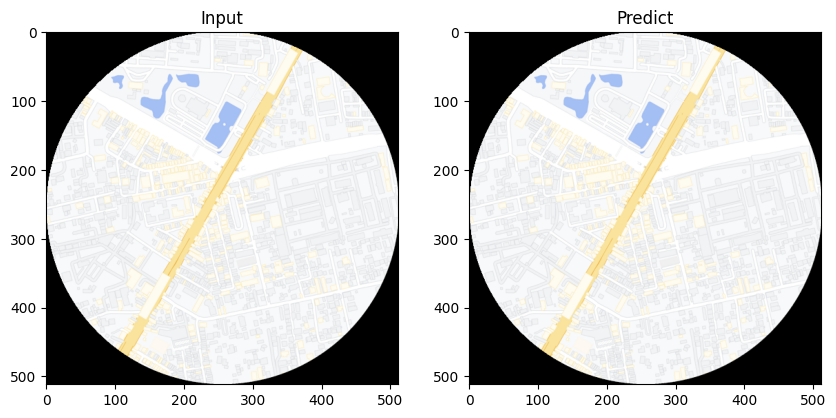

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


def show_image_result(image_path, fig_size=(10, 10), input_image_path=input_image_path):
    fig, axes = plt.subplots(1, 2, figsize=fig_size)

    # Load input image
    input_image = Image.open(input_image_path)
    axes[0].imshow(input_image)
    axes[0].set_title("Input")

    # Load search result image
    image = Image.open(image_path)
    axes[1].imshow(image)
    axes[1].set_title("Predict")

    plt.show()


for search_result, search_result_metadata in search_results:
    image_path = search_result.page_content
    show_image_result(image_path)
    break

/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/1025.png


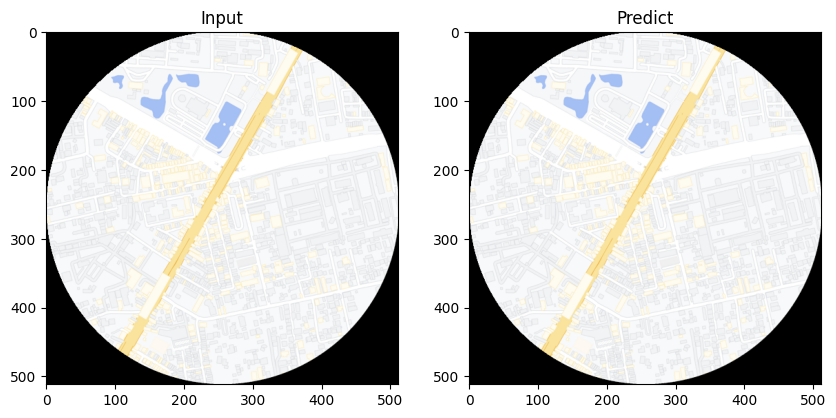

/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/3929.png


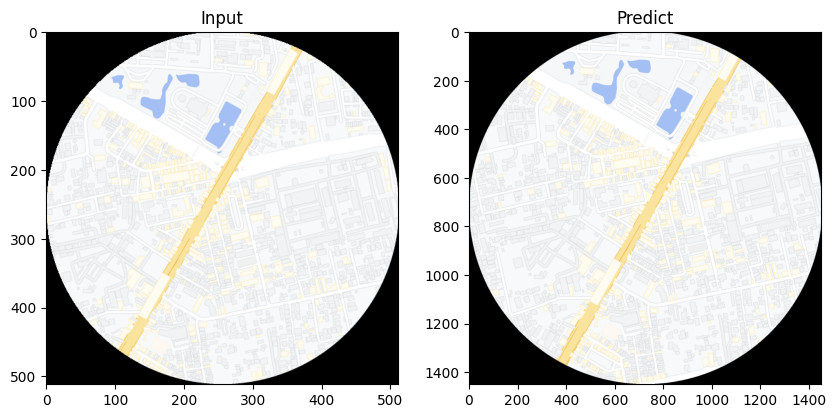

/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/15042.png


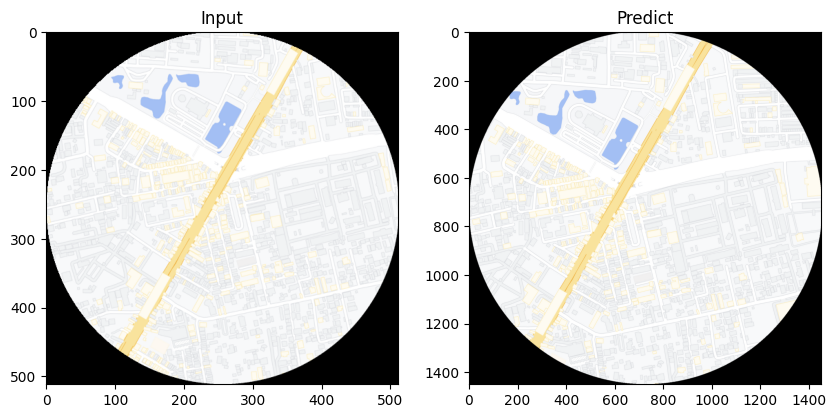

/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/9116.png


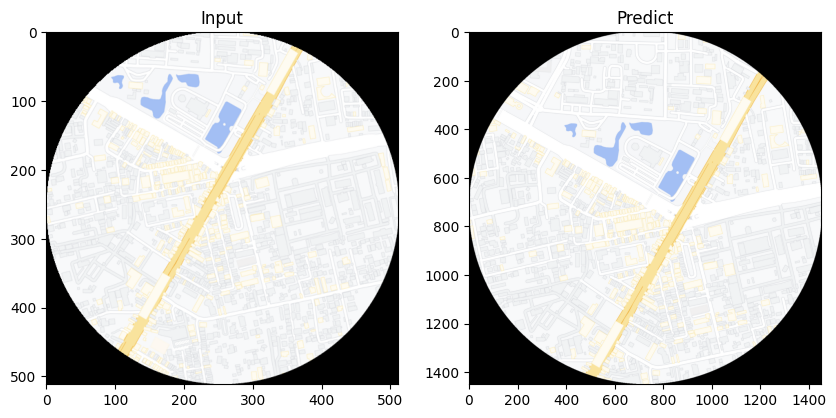

/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/9187.png


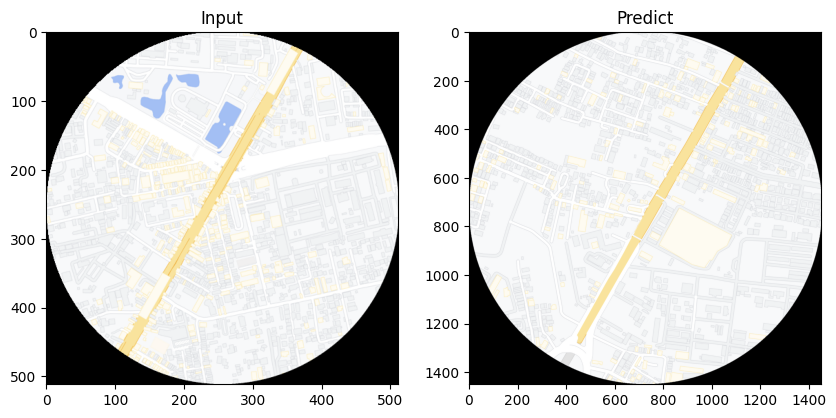

/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/5682.png


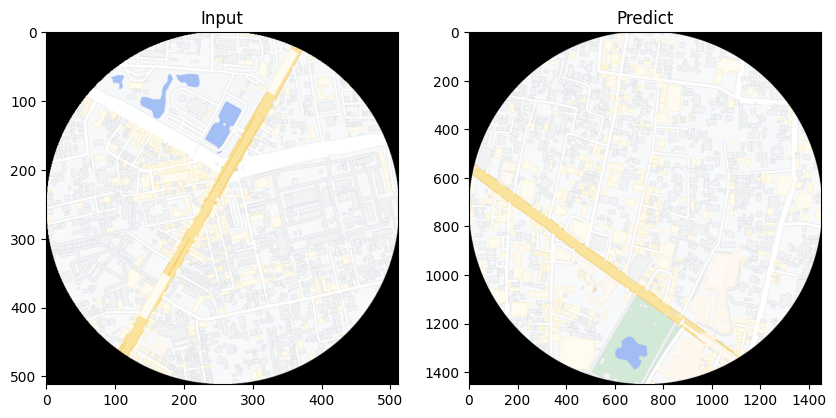

/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/821.png


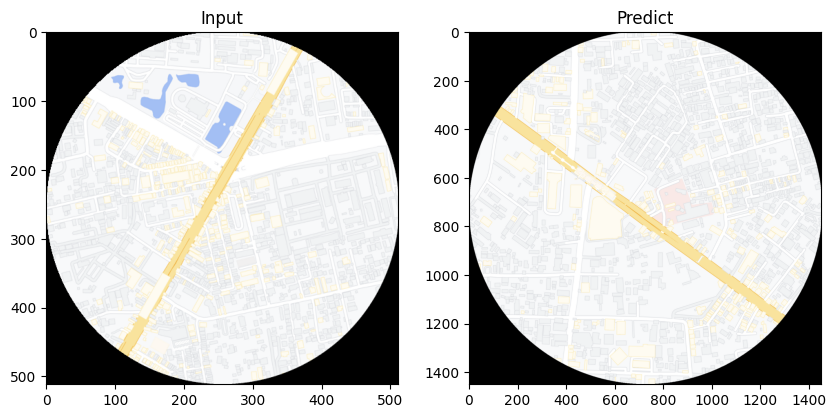

/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/10469.png


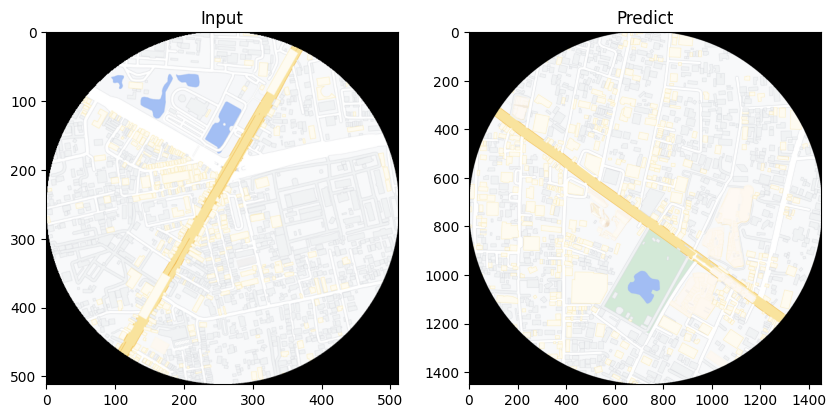

/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/108.png


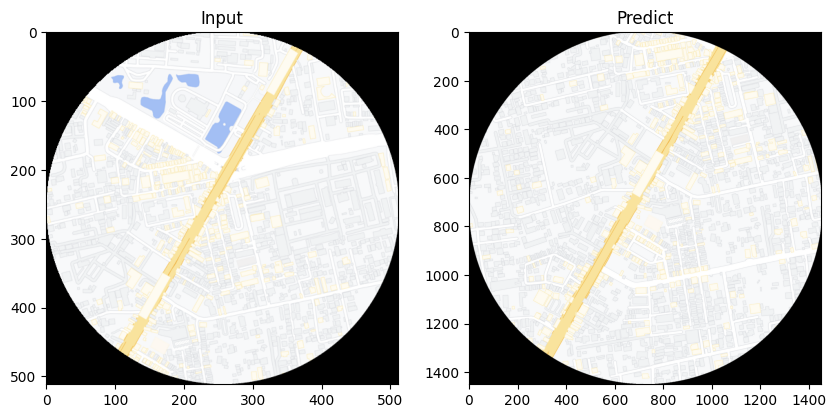

/Users/user/Documents/Coding/cro_location_intelligence/reverse_image_search/crop_image/2452.png


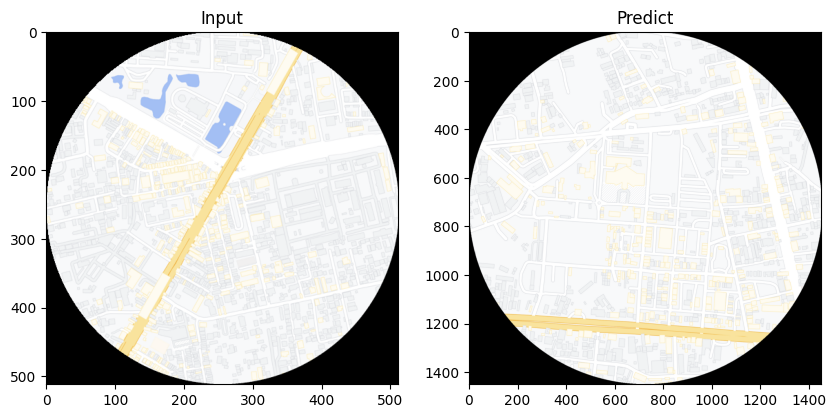

In [ ]:
for search_result, score in search_results[:10]:
    image_path = search_result.page_content
    image = Image.open(image_path)
    print(image_path)
    show_image_result(image_path)